<a href="https://colab.research.google.com/github/aisha-partha/AIMLOps-MiniProjects/blob/mp_4/M2_NB_MiniProject_2_DeepLabV3%2B_Lungs_Segmentation_Shivayogi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project: Lung Segmentation of Chest X-Ray dataset using DeepLabV3+

## Learning Objectives:

At the end of the experiment, you will be able to:

- understand, prepare, and visualize the the dataset containing image and corresponding masked image used for segmentation
- implement DeepLabV3+ architecture
- create a masked image (prediction)

## Introduction

Semantic segmentation is a computer vision task that involves dividing an image into different regions, each of which is labeled with a semantic category. The goal of semantic segmentation is to enable machines to understand the content of an image at a pixel level, by assigning a label to each individual pixel based on the object or region it belongs to.

This technique is widely used in many applications such as self-driving cars, medical image analysis, and object recognition in robotics. It helps to extract meaningful information from images and to understand the relationships between objects and their environment.

The below figure shows how semantic segmentation differs from other algorithms, such as object detection.

<br>
<img src='https://cdn.iisc.talentsprint.com/AIandMLOps/Images/segmentation_vs_other_algos.jpeg' width=700px>
<br><br>

Moreover, in contrast to object detection, which detects and localizes objects within an image, semantic segmentation is more precise and detailed. It provides a much more granular understanding of the content of an image, allowing for more advanced and accurate applications.

## Dataset

*  The Chest X-Ray dataset is made up of images and segmentated mask from two diffrent sources - Shenzhen and Montgomery dataset
*  The CXR_png folder consists of Chest X-Rays and the masks folder has the segmented mask
*  There are 704 images with their masks mapped with each other  

<br>
$\quad$<img src='https://cdn.extras.talentsprint.com/AIandMLOps/Images/semantic_segmentation.png' width=700px>
<br><br>


## Problem Statement

Perfrom the lungs segmentation on Chest X-Ray dataset using DeepLabV3+ model.

## Grading = 10 Points

In [3]:
#@title Download the data
!wget https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/LungSegmentation.zip
!unzip -qq LungSegmentation.zip
print("Data Downloaded Successfuly!!")

--2024-06-06 17:08:34--  https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/LungSegmentation.zip
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139904834 (133M) [application/zip]
Saving to: ‘LungSegmentation.zip’

LungSegmentation.zi 100%[===================>] 133.42M  11.7MB/s    in 13s     

2024-06-06 17:08:48 (9.98 MB/s) - ‘LungSegmentation.zip’ saved [139904834/139904834]

Data Downloaded Successfuly!!


### Import required packages

In [4]:
import os
import cv2
import numpy as np
from glob import glob
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### **PART-A**

### Data Visualization (1 point)

#### Image Visualization
Visualize one of the Chest X-Ray image and its segmented label image.

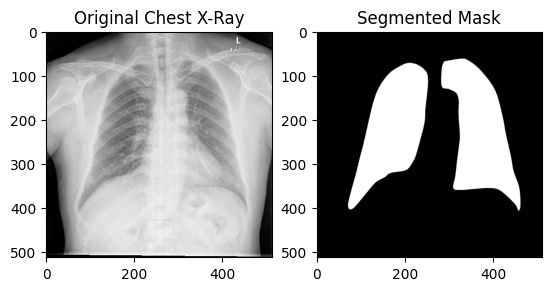

In [5]:
# Visualize an image
# YOUR CODE HERE
# Visualize an image
# Visualize a semantic part segmentation label image
# YOUR CODE HERE
# Load an example image and mask
image_path = '/content/LungSegmentation/CXR_png/CHNCXR_0001_0.png'
mask_path = '/content/LungSegmentation/masks/CHNCXR_0001_0.png'

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Chest X-Ray')

# Plot the segmented mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Segmented Mask')

plt.show()

In [6]:
# Visualize a semantic part segmentation label image
# YOUR CODE HERE

### Create a TensorFlow Dataset (1 points)
Use the image size, batch size, number of classes, and data directory as given in the below code cell.

Hint:
1. Find all the image files in the CXR_png and masks subdirectory separately. The resulting list should be sorted in ascending order.
2. Create a list of validation image, validation masks, test image, test masks, etc.
3. Create a function that reads an image file and returns a preprocessed image tensor.  

In [7]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 2
# Set your data directory
DATA_DIR = "./LungSegmentation"

# Find paths for all the image files in the 'CXR_png' subdirectory of the DATA_DIR directory.
# Sort the list of file paths in ascending order
all_images = [os.path.join(DATA_DIR, "CXR_png", filename) for filename in os.listdir(os.path.join(DATA_DIR, "CXR_png"))]

# Find paths for all the mask files in the 'masks' subdirectory of the DATA_DIR directory.
# Sort the list of file paths in ascending order
all_masks = [os.path.join(DATA_DIR, "masks", filename) for filename in os.listdir(os.path.join(DATA_DIR, "masks"))]


In [8]:
import random
#Cateogorizing images in 4 samples
images_sample1 = []
images_sample2 = []
images_sample3 = []
images_sample4 = []
for i in range(len(all_images)):
    if all_images[i].split('/')[-1].split('.')[0][0] == "C" and all_images[i].split('/')[-1].split('.')[0][-1] == "0":
        images_sample1.append(all_images[i])
    elif all_images[i].split('/')[-1].split('.')[0][0] == "C" and all_images[i].split('/')[-1].split('.')[0][-1] == "1":
        images_sample2.append(all_images[i])
    elif all_images[i].split('/')[-1].split('.')[0][0] == "M" and all_images[i].split('/')[-1].split('.')[0][-1] == "0":
        images_sample3.append(all_images[i])
    else:
        images_sample4.append(all_images[i])


# Randomly sample from each category of image
sampled_train_images = []
for images in [images_sample1, images_sample2, images_sample3, images_sample4]:
    sampled_train_images.extend(random.sample(images, int(0.7*len(images))))

sampled_val_test_images = []
sampled_val_images =[]
for images in [images_sample1, images_sample2, images_sample3, images_sample4]:
    for image in images:
        if image not in sampled_train_images:
            sampled_val_test_images.append(image)

sampled_val_images.extend(random.sample(sampled_val_test_images, int(0.5*len((sampled_val_test_images)))))

sampled_test_images =[]
for image in sampled_val_test_images:
    if image not in sampled_val_images:
        sampled_test_images.append(image)


print('all images :',len(all_images))
print ('Sample 1 : ', len(images_sample1))
print ('Sample 2 : ', len(images_sample2))
print ('Sample 3 : ', len(images_sample3))
print ('Sample 4 : ', len(images_sample4))
print ('Sampled Trained Images : ', len(sampled_train_images))
print ('Sampled Val Images : ', len(sampled_val_images))
print ('Sampled Test Images : ', len(sampled_test_images))




all images : 704
Sample 1 :  279
Sample 2 :  287
Sample 3 :  80
Sample 4 :  58
Sampled Trained Images :  491
Sampled Val Images :  106
Sampled Test Images :  107


In [9]:
#indexing the masks set to images
sampled_train_masks = []
sampled_val_masks= []
sampled_test_masks= []
for i in range(len(all_masks)):
    flag = 0
    for j in range(len(sampled_train_images)):
        if all_masks[i].split('/')[-1].split('.')[0] == sampled_train_images[j].split('/')[-1].split('.')[0]:
            sampled_train_masks.append(all_masks[i])
            flag = 1
            break
    if (flag == 0):
        for x in range(len(sampled_val_images)):
            if all_masks[i].split('/')[-1].split('.')[0] == sampled_val_images[x].split('/')[-1].split('.')[0]:
                sampled_val_masks.append(all_masks[i])
                flag = 1
                break
    if (flag == 0):
        sampled_test_masks.append(all_masks[i])


sampled_train_images = sorted(sampled_train_images)
sampled_val_images = sorted(sampled_val_images)
sampled_test_images = sorted(sampled_test_images)
sampled_train_masks = sorted(sampled_train_masks)
sampled_val_masks = sorted(sampled_val_masks)
sampled_test_masks = sorted(sampled_test_masks)

print(sampled_train_images[:5])
print(sampled_train_masks[:5])
print(sampled_val_images[:5])
print(sampled_val_masks[:5])
print(sampled_test_images[:5])
print(sampled_test_masks[:5])

['./LungSegmentation/CXR_png/CHNCXR_0001_0.png', './LungSegmentation/CXR_png/CHNCXR_0002_0.png', './LungSegmentation/CXR_png/CHNCXR_0003_0.png', './LungSegmentation/CXR_png/CHNCXR_0004_0.png', './LungSegmentation/CXR_png/CHNCXR_0005_0.png']
['./LungSegmentation/masks/CHNCXR_0001_0.png', './LungSegmentation/masks/CHNCXR_0002_0.png', './LungSegmentation/masks/CHNCXR_0003_0.png', './LungSegmentation/masks/CHNCXR_0004_0.png', './LungSegmentation/masks/CHNCXR_0005_0.png']
['./LungSegmentation/CXR_png/CHNCXR_0008_0.png', './LungSegmentation/CXR_png/CHNCXR_0014_0.png', './LungSegmentation/CXR_png/CHNCXR_0020_0.png', './LungSegmentation/CXR_png/CHNCXR_0022_0.png', './LungSegmentation/CXR_png/CHNCXR_0049_0.png']
['./LungSegmentation/masks/CHNCXR_0008_0.png', './LungSegmentation/masks/CHNCXR_0014_0.png', './LungSegmentation/masks/CHNCXR_0020_0.png', './LungSegmentation/masks/CHNCXR_0022_0.png', './LungSegmentation/masks/CHNCXR_0049_0.png']
['./LungSegmentation/CXR_png/CHNCXR_0019_0.png', './Lung

In [10]:
# Function to read an image file and returns a preprocessed image tensor.
# The mask argument is set to False by default, indicating that it is an image file, not a mask file.
from tensorflow import image as tf_image
from tensorflow import io as tf_io

def read_image(image_path, mask = False):  #Pre-processing Images

    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf_image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])

    # Normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    return image

Create a **load_data** function that takes in two arguments, **image_list** and **mask_list**, which are lists of file paths to the images and corresponding masks, respectively. It then reads in the image and mask using the **read_image** function defined earlier. The function returns a tuple of **image** and **mask**.

In [11]:
def load_data(image_path, mask_path):
    image = read_image(image_path)
    mask = read_image(mask_path, mask=True)
    return image, mask

#val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
#val_dataset = val_dataset.map(lambda x, y: (read_image(x), read_image(y, mask = True)))
#test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
#test_dataset = test_dataset.map(lambda x, y: (read_image(x), read_mask(y, mask = True)))

Create a **data_generator** function that takes in **image_list** and **mask_list** as arguments.

The function should:
- create a **tf.data.Dataset** object from the input data
- map the **load_data** function to each element in the dataset
- convert the dataset into batches of size **BATCH_SIZE**, drop any incomplete batch at the end of the dataset
- return the resulting dataset

In [12]:
# Generate train and validation set

def data_generator(image_list, mask_list):
    # Create a dataset from image and mask lists
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data)
    #Batch the dataset and drop any incomplete batch
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

    return dataset

train_dataset = data_generator(sampled_train_images, sampled_train_masks)
train_dataset = train_dataset.shuffle(buffer_size=len(sampled_train_images))
val_dataset = data_generator(sampled_val_images, sampled_val_masks)
test_dataset = data_generator(sampled_test_images, sampled_test_masks)

print('Train  Dataset: ', train_dataset)
print('Val  Dataset: ',  val_dataset)

# Example usage:
for batch in train_dataset.take(2):
    images_batch, masks_batch = batch
    print(images_batch.shape)  # Shape should be (batch_size, IMAGE_SIZE, IMAGE_SIZE, 3)
    print(masks_batch.shape)


Train  Dataset:  <_ShuffleDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val  Dataset:  <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
(4, 512, 512, 3)
(4, 512, 512, 1)
(4, 512, 512, 3)
(4, 512, 512, 1)


Check the total images for train and validation.

In [13]:
# YOUR CODE HERE
print('Total no images in Train set: ',len(train_dataset)*BATCH_SIZE)
print('Total no images in Val set: ',len(val_dataset)*BATCH_SIZE)


Total no images in Train set:  488
Total no images in Val set:  104


Check the number of batches formed in train and validation set.


In [14]:
# YOUR CODE HERE
print('Total no images in Train batches: ',int(len(train_dataset)))
print('Total no images in Val Batches: ',int(len(val_dataset)))

Total no images in Train batches:  122
Total no images in Val Batches:  26


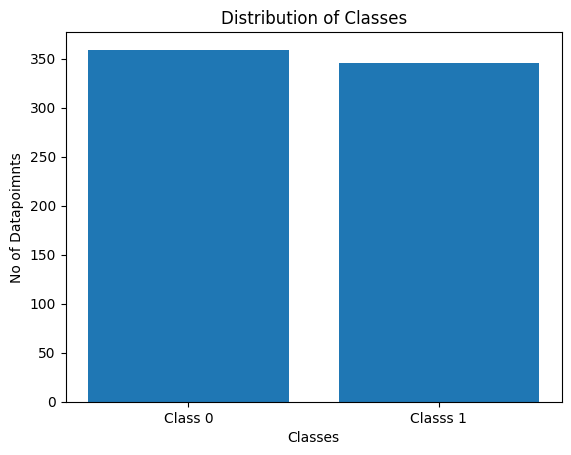

In [15]:
sample_Class_0 = images_sample1 + images_sample3
sample_Class_1 = images_sample2 + images_sample4

# Calculate lengths
length1 = len(sample_Class_0)
length2 = len(sample_Class_1)

# Create a bar plot
plt.bar(['Class 0', 'Classs 1'], [length1, length2])
plt.xlabel('Classes')
plt.ylabel('No of Datapoimnts')
plt.title('Distribution of Classes')
plt.show()

Now, we have created our TensorFlow Dataset. Further, let us try to understand the DeepLabV3+ model.

### **PART-B**

### Building the DeepLabV3+ model

Downsampling is widely adopted in deep convolutional neural networks (CNN) for reducing memory consumption while preserving the transformation invariance to some degree.

Multiple downsampling of a CNN will lead the feature map resolution to become smaller, resulting in lower prediction accuracy and loss of boundary information in semantic segmentation.

DeepLabv3+ helps in solving these issues by including **atrous convolutions**. They aggregate context around a feature which helps in segmenting it better.

<br>

#### **Atrous Convolution/Dilated Convolution**

It is a tool for refining the effective field of view of the convolution. It modifies the field of view using a parameter termed ***atrous rate*** or ***dilation rate***.

With dilated convolution, as we go deeper in the network, we can keep the stride constant but with larger field-of-view without increasing the number of parameters or the amount of computation. It also enables larger output feature maps, which is useful for semantic segmentation.

In the below figure, Atrous/Dilated Convolution has wider field of view with same number of parameters as Normal convolution.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/Dilated_Conv.jpg" width=500px>
<br><br>



#### **DeepLabv3+**

Earlier version, DeepLabv3 has a problem of consuming too much time to process high-resolution images. DeepLabv3+ is a semantic segmentation architecture that improves upon DeepLabv3 with several improvements, such as adding an effective decoder module to refine the segmentation results.

The below figure shows the typical architecture of DeepLabv3+. The encoder module processes multiscale contextual information by applying dilated/atrous convolution at multiple scales, while the decoder module refines the segmentation results along object boundaries.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/deeplabv3_plus_model.png" width=1000px>
<br><br>

Deeplabv3+ employs Aligned Xception network as its main feature extractor (encoder), although with substantial modifications. Depth-wise separable convolution replaces all max pooling procedures.

In Model Playground, we can select feature extraction (encoding) network to use as either **Resnet** or EfficientNet.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the sampling rate becomes larger, the number of valid filter weights (i.e., weights that are applied to the valid feature region, instead of padded zeros) becomes smaller.


### Create the model (5 points)
First, create different functions  to implement DeepLabV3+ architecture.



Create a function, **convolution_block()**, to add a convolution layer, a BatchNormalization layer, and apply ReLu activation in one go.

In [16]:
# YOUR CODE HERE
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Concatenate

'''
def convolution_block(inputs, filters, kernel_size, strides=(1, 1), padding='same', activation='relu'):
    """
    Adds a convolution layer followed by a BatchNormalization layer and ReLU activation.

    Parameters:
    - inputs: Input tensor.
    - filters: Integer, the dimensionality of the output space (i.e., the number of output filters in the convolution).
    - kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window.
    - strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width.
    - padding: One of "valid" or "same" (case-insensitive).
    - activation: Activation function to use. If you don't specify anything, no activation is applied.

    Returns:
    - Output tensor.
    """
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(inputs)
    x = BatchNormalization()(x)
    if activation:
        x = Activation(activation)(x)
    return x
'''

def convolution_block(x, filters, kernel_size, dilation_rate=1):
    """Applies Convolution -> Batch Normalization -> ReLU"""
    x = Conv2D(filters, kernel_size, dilation_rate=dilation_rate, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x




# Example usage:
# Assuming `inputs` is the input tensor to your network
# inputs = tf.keras.Input(shape=(height, width, channels))
# x = convolution_block(inputs, filters=64, kernel_size=(3, 3))
# model = tf.keras.Model(inputs=inputs, outputs=x)


Create another function to perform **Dilated Spatial Pyramid Pooling**. Use above function to add different convolution blocks.

In [17]:
# YOUR CODE HERE
def dilated_spatial_pyramid_pooling(inputs, filters, rates):
    """Applies dilated convolutions at different rates and concatenates the results."""
    # Feature maps from the dilated convolutions at different rates
    feature_maps = [inputs]  # Start with the original inputs as one of the streams
    for rate in rates:
        fm = convolution_block(inputs, filters, kernel_size=3, dilation_rate=rate)
        feature_maps.append(fm)

    # Concatenate all the feature maps
    outputs = Concatenate()(feature_maps)
    return outputs

# Example usage in a model context:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

inputs = Input(shape=(None, None, 3))  # Example input shape, replace with actual dimensions
dspp_output = dilated_spatial_pyramid_pooling(inputs, filters=256, rates=[1, 6, 12, 18])
model = Model(inputs=inputs, outputs=dspp_output)

# Display the model summary to see the architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 256)      7168      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 256)      7168      ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, None, None, 256)      7168      ['input_1[0][0]']             
                                                                                              

The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features from the network backbone that have the same spatial resolution. Here, we use a **ResNet50** pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

##### Exploring ResNet-50 architecture before using it.

In [18]:
res_input = keras.Input(shape=(128, 128, 3))
resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor = res_input)

# Layers present in ResNet-50 network
resnet50.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                      

From the above layers,

- Use the low-level features from the `conv2_block3_2_relu` layer of the ResNet-50 network to fead in Decoder.

- Use the features from the `conv4_block6_2_relu` layer of the ResNet-50 to fead in Dilated Spatial Pyramid Pooling module.

#### Create Encoder
Create a function to implement the architecture for Encoder block. Use **ResNet50** pretrained on ImageNet as the backbone network. Use the features from the **conv4_block6_2_relu** layer of the backbone to fead in Dilated Spatial Pyramid Pooling module. Then return the backbone network along with encoder output.

In [19]:
# YOUR CODE HERE
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def create_encoder():
    # Load the pre-trained ResNet-50 model
    base_model = ResNet50(weights='imagenet', include_top=False)

    # You can choose to make layers non-trainable based on your fine-tuning strategy
    for layer in base_model.layers:
        layer.trainable = True

    # Define the output of the encoder as the output of a specific layer
    encoder_output = base_model.get_layer('conv4_block6_2_relu').output

    # Create the encoder model
    encoder = Model(inputs=base_model.input, outputs=encoder_output)

    return base_model, encoder

# Usage
base_model, encoder = create_encoder()
encoder.summary()  # Display the structure of the encoder


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                        

#### Create Decoder

Create a function to implement the architecture for Decoder block. The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features (the **conv2_block3_2_relu** layer) from the network backbone that have the same spatial resolution.

In [20]:
# YOUR CODE HERE
import tensorflow as tf
from tensorflow.keras import layers, models

def decoder(encoder_features, low_level_features):
    """
    Args:
        encoder_features: Output from the encoder which will be upsampled.
        low_level_features: Output from a low-level layer in the backbone (e.g., conv2_block3_2_relu).

    Returns:
        A Keras model output from the decoder.
    """
    # Bilinearly upsample the encoder features by a factor of 4
    upsampled_features = tf.image.resize(encoder_features,
                                         size=[low_level_features.shape[1] * 4, low_level_features.shape[2] * 4],
                                         method=tf.image.ResizeMethod.BILINEAR)

    # Concatenate upsampled encoder features with low-level features
    concatenated_features = layers.Concatenate()([upsampled_features, low_level_features])

    # Additional layers can be added here, such as convolutional layers to process concatenated features
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concatenated_features)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Output layer
    output = layers.Conv2D(3, (1, 1), activation='sigmoid')(x)  # Adjust the number of filters based on the number of classes

    return output

# Example of how to use this function with a hypothetical encoder output and low-level feature
# encoder_output and low_level_output would be obtained from your full model's specific layers
# For example:
# encoder_output = encoder_model.output
# low_level_output = resnet50.get_layer('conv2_block3_2_relu').output
# decoded_output = decoder(encoder_output, low_level_output)


#### Building full architecture of the Model

Write a function that combines the encoder and decoder functions defined above to create & implement a complete  DeepLabV3+ architecture.

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications

def create_deeplabv3_plus(input_shape=(224, 224, 3), num_classes=3):
    """
    Create a DeepLabV3+ model using ResNet-50 as the backbone.

    Args:
        input_shape (tuple): The shape of the input images.
        num_classes (int): The number of classes in the segmentation task.

    Returns:
        A Keras model representing the DeepLabV3+ architecture.
    """
    # Load ResNet-50 pretrained on ImageNet without the top layer
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=input_shape))

    # Extract features from the layers we need
    encoder_output = base_model.get_layer('conv4_block6_2_relu').output
    low_level_features = base_model.get_layer('conv2_block3_2_relu').output

    # Dilated Spatial Pyramid Pooling
    # Applying different atrous rates
    x = layers.Conv2D(256, (3, 3), dilation_rate=(6, 6), padding='same', activation='relu')(encoder_output)
    x = layers.Conv2D(256, (3, 3), dilation_rate=(12, 12), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), dilation_rate=(18, 18), padding='same', activation='relu')(x)

    # Upsample x to have the same dimensions as low_level_features
    x = layers.UpSampling2D(size=(4, 4))(x)  # Change the size based on the specific scaling factor needed

    # Combining the Atrous and low-level features
    x = layers.Concatenate()([x, low_level_features])

    # Create the decoder block
    # Example of a simple decoder: Upsample again and finish with a convolutional layer to predict the segmentation masks
    x = layers.UpSampling2D(size=(4, 4))(x)
    x = layers.Conv2D(num_classes, (3, 3), padding='same', activation='softmax')(x)

    # Build the model
    model = models.Model(inputs=base_model.input, outputs=x)

    return model





In [22]:
# Create model
# Create the DeepLabV3+ model
deeplab_model = create_deeplabv3_plus(input_shape=(512, 512, 3), num_classes=3)
deeplab_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [40]:
import tensorflow as tf

def iou(y_true, y_pred):
    # Apply sigmoid or softmax if your model outputs logits
    y_pred = tf.nn.softmax(y_pred)  # Change to softmax for multi-class, sigmoid for binary
    threshold = 0.5
    y_pred = tf.cast(y_pred > threshold, tf.float32)  # Ensure y_pred is cast to float
    y_true = tf.cast(y_true, tf.float32)  # Ensure y_true is cast to float

    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    # Compute IoU
    return intersection / union


### Training (1 point)

We train the model using sparse categorical crossentropy as the loss function, and
Adam as the optimizer.

##### Compile model


In [41]:
# YOUR CODE HERE
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Assuming 'deeplab_model' is your DeepLabV3+ model instance

"""
# Compile the model
deeplab_model.compile(
    optimizer=Adam(learning_rate=0.001),  # You can adjust the learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Using from_logits=True if your model returns logits
    metrics=['accuracy']  # You can track more metrics like precision, recall, etc.
)
"""

deeplab_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', iou]  # Added IoU here alongside accuracy
)


In [42]:
for images, masks in train_dataset.take(1):
    print("Image batch shape: ", images.shape)
    print("Mask batch shape: ", masks.shape)

Image batch shape:  (4, 512, 512, 3)
Mask batch shape:  (4, 512, 512, 1)


##### Model Training

In [43]:
# YOUR CODE HERE
# Train the model
history = deeplab_model.fit(
    train_dataset,
    epochs=10,  # Number of epochs to train
    validation_data=val_dataset,
    verbose=1  # Show progress bar
)


Epoch 1/10
122/122 [==============================] - 69s 351ms/step - loss: 0.0508 - accuracy: 0.9752 - iou: 0.2380 - val_loss: 0.2907 - val_accuracy: 0.9095 - val_iou: 0.2025
Epoch 2/10
122/122 [==============================] - 46s 364ms/step - loss: 0.0470 - accuracy: 0.9761 - iou: 0.2380 - val_loss: 0.1977 - val_accuracy: 0.9379 - val_iou: 0.2182
Epoch 3/10
122/122 [==============================] - 45s 350ms/step - loss: 0.0437 - accuracy: 0.9771 - iou: 0.2382 - val_loss: 0.2078 - val_accuracy: 0.9286 - val_iou: 0.2424
Epoch 4/10
122/122 [==============================] - 44s 347ms/step - loss: 0.0419 - accuracy: 0.9777 - iou: 0.2384 - val_loss: 0.2092 - val_accuracy: 0.9257 - val_iou: 0.2160
Epoch 5/10
122/122 [==============================] - 45s 351ms/step - loss: 0.0391 - accuracy: 0.9786 - iou: 0.2386 - val_loss: 0.0905 - val_accuracy: 0.9598 - val_iou: 0.2466
Epoch 6/10
122/122 [==============================] - 47s 371ms/step - loss: 0.0379 - accuracy: 0.9790 - iou: 0.238

We can plot the training and validation loss to see how the training went. This should show generally decreasing values per epoch.

#####  Learning curve from model history (1 point)

In [44]:
#
# YOUR CODE HERE
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    """
    Plot the learning curves of training and validation loss and accuracy from the training history.

    Args:
    history: A Keras History object returned from the fit method of a model.
    """
    epochs = range(len(history.history['loss']))

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Check if accuracy is in the history keys to plot it
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
        plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()


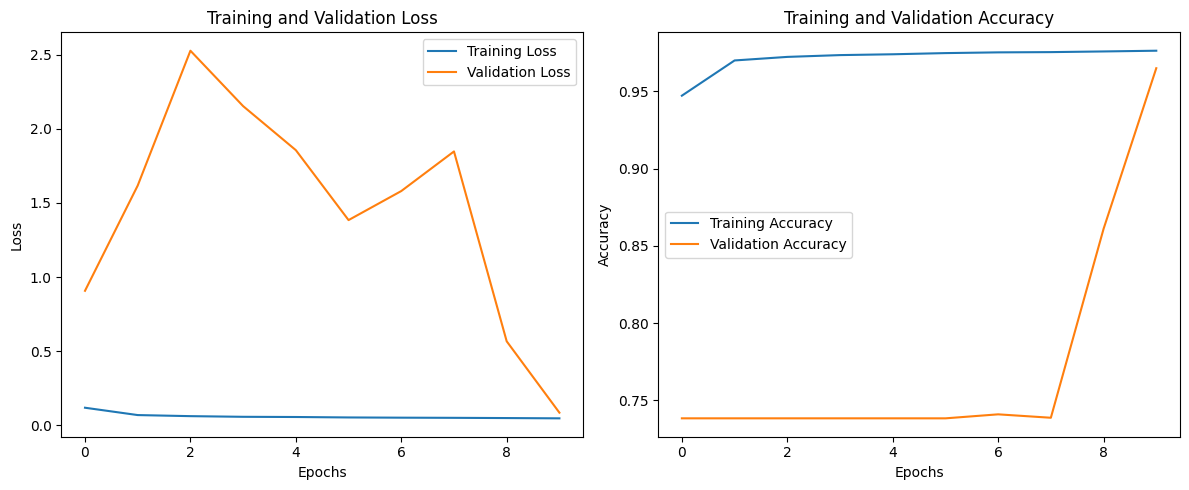

In [31]:
# Display learning curves
# YOUR CODE HERE
plot_learning_curves(history)

### Visualize Predictions (1 points)

In [28]:
# Inference from model
# YOUR CODE HERE

#### Plot the predictions

1/1 [==============================] - 0s 47ms/step


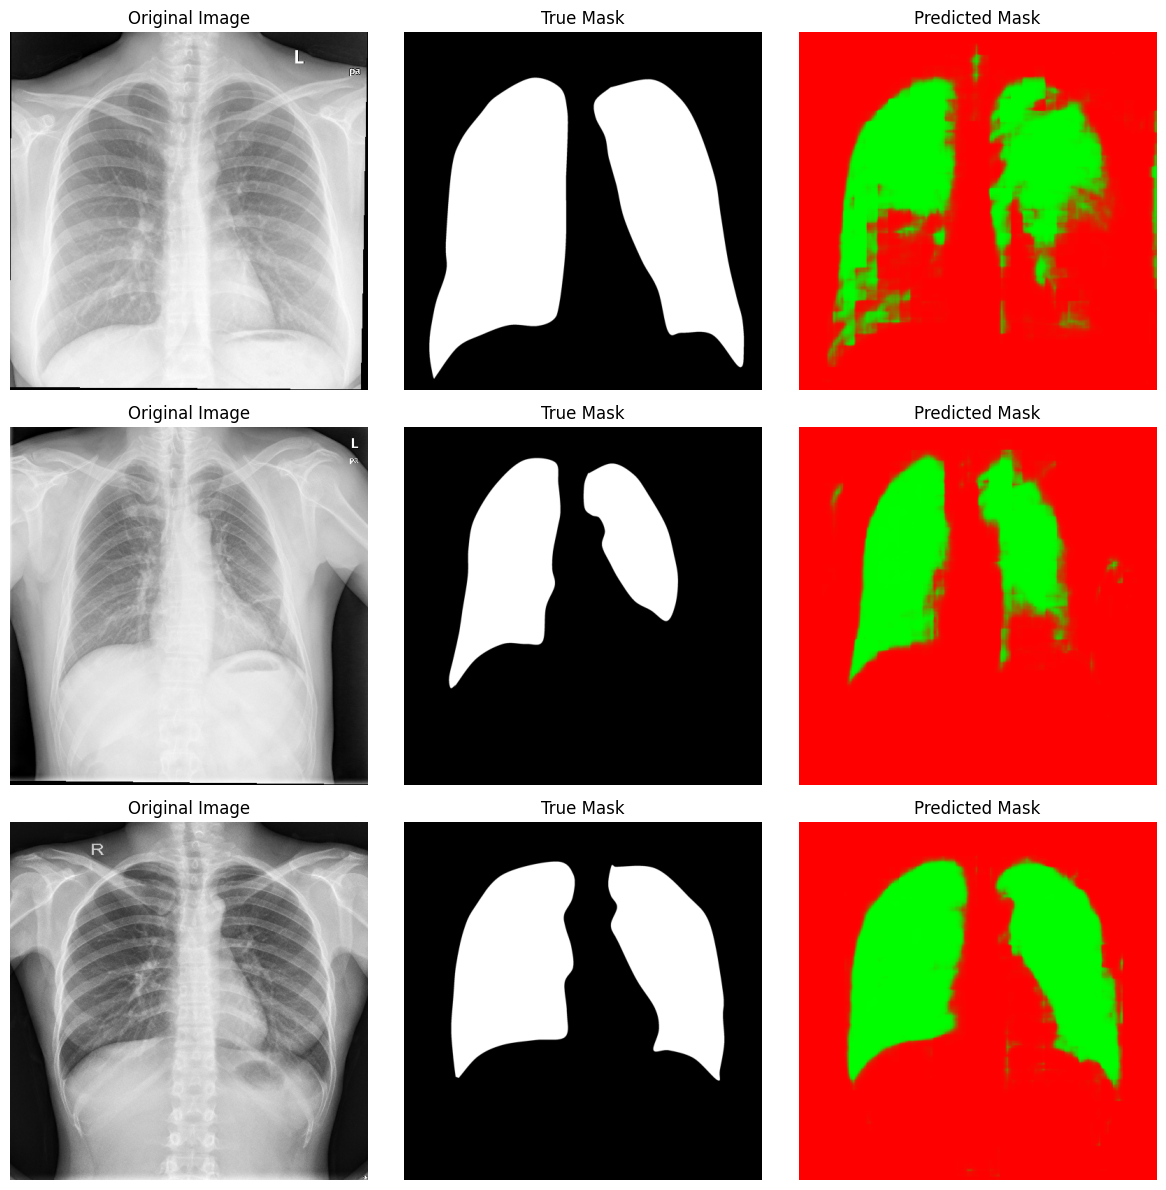

In [45]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_predictions(model, dataset, num_examples=3):
    """
    Visualizes predictions for a dataset.

    Parameters:
        model: The trained TensorFlow/Keras model.
        dataset: A tf.data.Dataset providing (image, mask) tuples.
        num_examples: Number of examples to visualize.
    """
    plt.figure(figsize=(12, num_examples * 4))

    for images, masks in dataset.take(num_examples):
        preds = model.predict(images)
        for i in range(num_examples):
            plt.subplot(num_examples, 3, i * 3 + 1)
            plt.imshow(tf.squeeze(images[i]), cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(num_examples, 3, i * 3 + 2)
            plt.imshow(tf.squeeze(masks[i]), cmap='gray')
            plt.title('True Mask')
            plt.axis('off')

            plt.subplot(num_examples, 3, i * 3 + 3)
            plt.imshow(tf.squeeze(preds[i]), cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `test_dataset` is your testing dataset and `trained_model` is your model.
plot_predictions(deeplab_model, test_dataset, num_examples=3)
